<a href="https://colab.research.google.com/github/InMyDream21/Deep-Learning/blob/main/Tensorflow/zerotomastery/computer_vision/Transfer_learning_in_TensorFlow_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now its time to learn about a new kind of transfer learning: fine-tuning

In [ ]:
# Check if we're using a GPU
!nvidia-smi

Fri Jan 14 06:22:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebook, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, its a good idea to put function youll want to use again in a script you can download and import into your notebooks (or elsewhere).

Weve done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-14 06:22:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-14 06:22:38 (74.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> **Note:** If youre running this notebook in Google Colab, when it times our Colab will delete `helper_function`, so youll have to redownload it if you want to access to your helper functions

## Lets get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them yo our own problem (recognizing images of food). 

In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-01-14 06:22:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 64.233.170.128, 108.177.11.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   184MB/s    in 0.9s    

2022-01-14 06:22:41 (184 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = 32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[178.64285    184.64285    198.64285   ]
   [179.15083    185.15083    199.15083   ]
   [179.64285    185.64285    199.64285   ]
   ...
   [169.84662    177.84662    196.84662   ]
   [168.43301    176.43301    195.43301   ]
   [167.64285    175.64285    194.64285   ]]

  [[181.92857    187.92857    201.92857   ]
   [181.92857    187.92857    201.92857   ]
   [182.24554    188.24554    202.24554   ]
   ...
   [173.24553    181.24553    200.24553   ]
   [171.71873    179.71873    198.71873   ]
   [170.92857    178.92857    197.92857   ]]

  [[183.63553    189.63553    203.63553   ]
   [184.21428    190.21428    204.21428   ]
   [184.28221    190.28221    204.28221   ]
   ...
   [175.74553    183.74553    202.74553   ]
   [174.21873    182.21873    201.21873   ]
   [173.42857    181.42857    200.42857   ]]

  ...

  [[160.78574    165.78574    184.78574   ]
   [159.99556    164.99556    183.99556   ]
   [159.46877    164.46877    183.46877   ]
   ...
   [193.         196.   

## Model 0: Building a transfer learning feature extraction model using the KEras Functional API

The sequential API is straight-forward, it runs our layers in sequential order

But the functional API gives us more flexibility with our models.

In [ ]:
# 1. Create the base model with tf.keras.application
base_model = tf.keras.applications.EfficientNetB0(include_top = False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = "input_layer")

# 4. If using a model like ResNet50v2 you will need to normalize inputs (you dont have to for efficientnet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255)(inputs)

# 5. Pass the input to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computation)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

# 8. Combine the inputs with the output into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# 10. Fit the model
history_10_percent = model_0.fit(train_data_10_percent,
                     epochs = 5,
                     steps_per_epoch = len(train_data_10_percent),
                     validation_data = test_data,
                     validation_steps = int(0.25 * len(test_data)),
                     callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                              experiment_name = "10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220114-062249
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - 21s 261ms/step - loss: 1.9443 - accuracy: 0.3613 - val_loss: 1.3907 - val_accuracy: 0.6891
Epoch 2/5
24/24 [==============================] - 5s 193ms/step - loss: 1.1746 - accuracy: 0.7387 - val_loss: 0.9291 - val_accuracy: 0.8076
Epoch 3/5
24/24 [==============================] - 5s 190ms/step - loss: 0.8637 - accuracy: 0.8107 - val_loss: 0.7589 - val_accuracy: 0.8306
Epoch 4/5
24/24 [==============================] - 4s 160ms/step - loss: 0.6993 - accuracy: 0.8320 - val_loss: 0.6489 - val_accuracy: 0.8438
Epoch 5/5
24/24 [==============================] - 5s 189ms/step - loss: 0.6156 - accuracy: 0.8627 - val_loss: 0.5968 - val_accuracy: 0.8487


In [ ]:
# Evaluate on the full dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 82ms/step - loss: 0.6210 - accuracy: 0.8372


[0.6210415363311768, 0.8371999859809875]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
# How about a summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


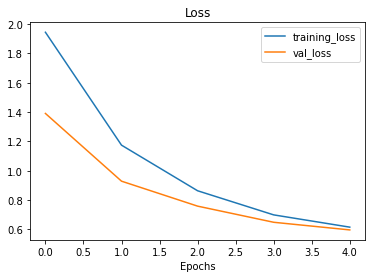

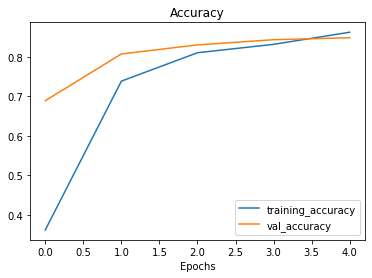

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Gloval Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)..

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Lets use a similar shape tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor} \n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Pass the random tensor through a global max pooling 2D layer
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"2D Global max pooled random tensor:\n {global_max_pooled_tensor}\n")

#Check the shape
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")
print(f"Shape of Global Max Pooled 2D tensor: {global_max_pooled_tensor.shape}")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

2D Global max pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)
Shape of Global Max Pooled 2D tensor: (1, 3)


In [ ]:
# Lets replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis = [1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [ ]:
# Lets replicate the GlobalMaxPool2D layer
tf.reduce_max(input_tensor, axis = [1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

## Running a series of transfer learning experiments

Weve seen the incredible result transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... How about we set up a bunch of experiments to find out:

1. `model_1` - Use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - Use feature extraction tansfer learning wih 10% of the training with data augmentation
3. `model_3` - Use fine-tuning transfer learning on 10% of the traiing data with data augmentation
4. `model_4` - Use fine-tuning transfer learning on 100% of the training data with data augmentation

>Note: throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

## Getting and preprocessing data for model_1

In [ ]:
# Download and unzip data - Preprocessed from food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

# Unzip the data
unzip_data("10_food_classes_1_percent.zip")

--2022-01-14 06:23:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.128, 74.125.31.128, 173.194.210.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   181MB/s    in 0.7s    

2022-01-14 06:23:43 (181 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test dir
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
# How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There a

In [ ]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow data augmentation documentation.

Such as:
* Preprocessing of images (augmenting them) happens on the GPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage wityh horizontal flipping, rotations, zooms, etc.
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescale(1/255) # Keep for models like ResNet50V2 but EfficientNet has rescaling built in
], name = "data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

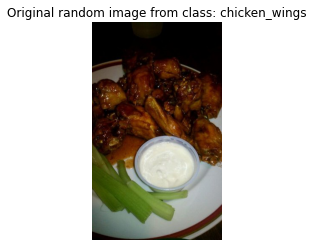

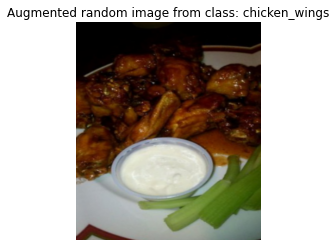

In [ ]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now lets plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis = 0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(input_shape,
                      name = "input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and dont train it
x = base_model(x, training = False)

# Pool the output features of the base model
x = layers.GlobalAveragePooling2D(name = "global_average_pool_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(len(test_data) * 0.25),
                                callbacks = [create_tensorboard_callback("transfer_learning",
                                                                         experiment_name = "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220114-062348
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


3/3 [==============================] - 11s 2s/step - loss: 2.3443 - accuracy: 0.1714 - val_loss: 2.2413 - val_accuracy: 0.1793
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1681 - accuracy: 0.2143 - val_loss: 2.1207 - val_accuracy: 0.2385
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9411 - accuracy: 0.3857 - val_loss: 2.0118 - val_accuracy: 0.3026
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8557 - accuracy: 0.5000 - val_loss: 1.9151 - val_accuracy: 0.3701
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6204 - accuracy: 0.6714 - val_loss: 1.8267 - val_accuracy: 0.4079


In [ ]:
# Check out a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pool_layer (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 7s 79ms/step - loss: 1.8240 - accuracy: 0.4336


[1.8240140676498413, 0.4336000084877014]

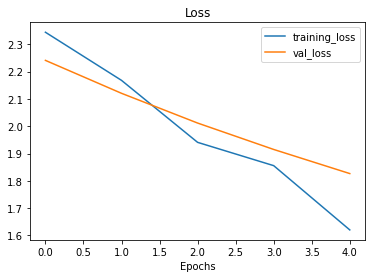

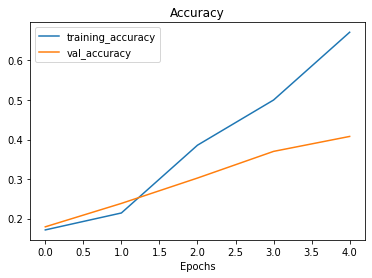

In [ ]:
# How does the model with data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning model with 10% of data and data augmentation

In [ ]:
# Since we already have the data so lets jst use it

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1/255) 
], name = "data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape = input_shape, name = "input_layer")
x = data_augmentation(inputs) # Augment our training images
x = base_model(x, training = False) # Pass the augmented images to the base model but keep it in inference mode, this also insures batchnorm layers dont get updated
x = layers.GlobalAveragePooling2D(name = "Global_average_pool2D")(x)
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

### Creating a model checkpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = "epoch", #save every epoch
                                                         verbose = 1)

### Fit model 2 passing in the ModelCheckpoint callbacks

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs = initial_epochs,
                                          steps_per_epoch = len(train_data_10_percent),
                                          validation_data = test_data,
                                          validation_steps = int(len(test_data) * 0.25),
                                          callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                   experiment_name = "10_percent_data_aug"),
                                                       checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220114-062436


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0248 - accuracy: 0.3373
Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 18s 517ms/step - loss: 2.0248 - accuracy: 0.3373 - val_loss: 1.5179 - val_accuracy: 0.6431
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3778 - accuracy: 0.6627
Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 387ms/step - loss: 1.3778 - accuracy: 0.6627 - val_loss: 1.0608 - val_accuracy: 0.7599
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0542 - accuracy: 0.7520
Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 9s 364ms/step - loss: 1.0542 - accuracy: 0.7520 - val_loss: 0.8540 - val_accuracy: 0.7993
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8983 - a

In [ ]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 7s 77ms/step - loss: 0.6210 - accuracy: 0.8372


[0.6210414171218872, 0.8371999859809875]

In [ ]:
# Check model_2 results on all test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 7s 78ms/step - loss: 0.6974 - accuracy: 0.8012


[0.6974115371704102, 0.8011999726295471]

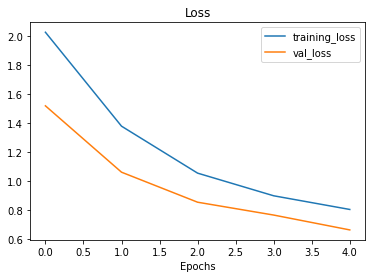

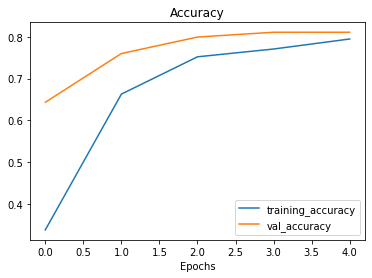

In [ ]:
# Plot model loss curves 
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to aspecific checkpoints.

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 77ms/step - loss: 0.6974 - accuracy: 0.8012


In [ ]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked
results_10_percent_data_aug == loaded_weights_model_results

True

In [ ]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[0. 0.]


## Model 3: Fine-tunin an existing model on 10% of the data

> **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe7daf84c50> True
<keras.engine.sequential.Sequential object at 0x7fe7daf66b10> True
<keras.engine.functional.Functional object at 0x7fe7daa90cd0> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fe7dab7f150> True
<keras.layers.core.dense.Dense object at 0x7fe7daac8f10> True


In [ ]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin fine tuning, lets start by setting the last 10 layers of our base_model.trainable = true
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # when fine-tuning you tipically want to lower the learning rate by 10x*
                metrics = ["accuracy"])

> **Note:** When using fine-tuning its best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumbs is at least 10x (though different sources wil claim other values).
A good resource for information on this is the ULMFit paper

In [ ]:
# Check which layer are tunable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# now weve unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = int(0.25 * len(test_data)),
                                               initial_epoch = history_10_percent_data_aug.epoch[-1], #Start training from previous last epoch
                                               callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                        experiment_name = "10_percent_fine_tuned_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tuned_last_10/20220114-062604
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - 18s 463ms/step - loss: 0.7206 - accuracy: 0.7960 - val_loss: 0.5798 - val_accuracy: 0.8207
Epoch 6/10
24/24 [==============================] - 10s 374ms/step - loss: 0.5825 - accuracy: 0.8293 - val_loss: 0.5150 - val_accuracy: 0.8224
Epoch 7/10
24/24 [==============================] - 9s 369ms/step - loss: 0.4961 - accuracy: 0.8587 - val_loss: 0.4784 - val_accuracy: 0.8372
Epoch 8/10
24/24 [==============================] - 9s 358ms/step - loss: 0.4357 - accuracy: 0.8667 - val_loss: 0.4751 - val_accuracy: 0.8405
Epoch 9/10
24/24 [==============================] - 9s 347ms/step - loss: 0.4033 - accuracy: 0.8747 - val_loss: 0.5125 - val_accuracy: 0.8174
Epoch 10/10
24/24 [==============================] - 9s 342ms/step - loss: 0.4047 - accuracy: 0.8747 - val_loss: 0.4782 - val_accuracy: 0.8224


In [ ]:
# Evaluate the fine-tuned model (model_3 which is acutally model_2 fine-tuned for another 5 epoch)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 79ms/step - loss: 0.4865 - accuracy: 0.8324


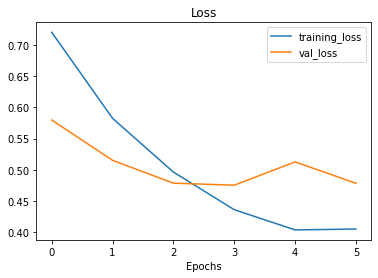

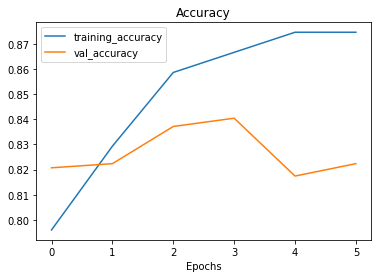

In [ ]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning)

In [ ]:
# Lets create a function to compare training histories
def compare_history(original_history, new_history, initial_epochs = 5):
  """
  Compares two TensorFlow history objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]


  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots for Accurcay
  plt.figure(figsize = (8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label = "Training Accuracy")
  plt.plot(total_val_acc, label = "Validation Accuracy")
  plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label = "Start Fine Tuning")
  plt.legend(loc = "lower right")
  plt.title("Training and Validation Accuracy")

  # Make plots for loss
  plt.figure(figsize = (8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label = "Training Loss")
  plt.plot(total_val_loss, label = "Validation Loss")
  plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label = "Start Fine Tuning")
  plt.legend(loc = "upper right")
  plt.title("Training and Validation Loss")

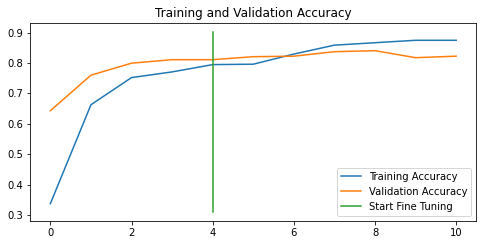

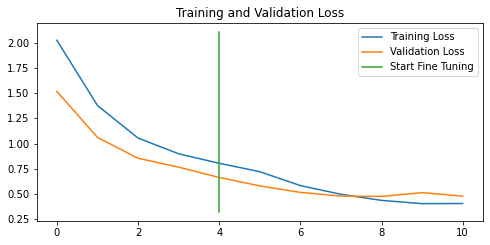

In [ ]:
compare_history(history_10_percent_data_aug,
                history_fine_10_percent_data_aug,
                initial_epochs = 5)

## Model 4: Fine-tuning an existing model on all of the data

In [ ]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-01-14 06:29:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.128, 173.194.216.128, 64.233.170.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   268MB/s    in 1.8s    

2022-01-14 06:29:53 (268 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode = "categorical",
                                                                                 image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset weve loaded in is the same as what weve been using for previous experiments (all experiments have used the same test dataset).

In [ ]:
# Evaluate model 2 (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 7s 79ms/step - loss: 0.4865 - accuracy: 0.8324


[0.4864670932292938, 0.8324000239372253]

In [ ]:
results_fine_tune_10_percent

[0.4864671528339386, 0.8324000239372253]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [ ]:
# Load weights from checkpoint, that way we can fine-tune from the same stage
# the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [ ]:
# Lets evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 7s 80ms/step - loss: 0.6974 - accuracy: 0.8012


[0.6974115967750549, 0.8011999726295471]

In [ ]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6974115371704102, 0.8011999726295471]

Alright, the previous steps might seem quite confusing but all weve done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` Callback
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training log each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4).

In [ ]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 Global_average_pool2D True
4 output_layer True


In [ ]:
# Lets drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Compile the model after making a change to the model
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                metrics = ["accuracy"])

In [ ]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs = fine_tune_epochs,
                                           validation_data = test_data,
                                           validation_steps = int(0.25 * len(test_data)),
                                           initial_epoch = history_10_percent_data_aug.epoch[-1],
                                           callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                    experiment_name = "full_10_classes_fine_tuned_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tuned_last_10/20220114-065107
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


235/235 [==============================] - 61s 233ms/step - loss: 0.7361 - accuracy: 0.7636 - val_loss: 0.4084 - val_accuracy: 0.8651
Epoch 6/10
235/235 [==============================] - 48s 199ms/step - loss: 0.5873 - accuracy: 0.8136 - val_loss: 0.3813 - val_accuracy: 0.8783
Epoch 7/10
235/235 [==============================] - 44s 184ms/step - loss: 0.5371 - accuracy: 0.8253 - val_loss: 0.3483 - val_accuracy: 0.9046
Epoch 8/10
235/235 [==============================] - 45s 190ms/step - loss: 0.4814 - accuracy: 0.8439 - val_loss: 0.3295 - val_accuracy: 0.9079
Epoch 9/10
235/235 [==============================] - 39s 166ms/step - loss: 0.4568 - accuracy: 0.8504 - val_loss: 0.3255 - val_accuracy: 0.9079
Epoch 10/10
235/235 [==============================] - 35s 149ms/step - loss: 0.4234 - accuracy: 0.8663 - val_loss: 0.3375 - val_accuracy: 0.8980


In [ ]:
# Lets evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 7s 79ms/step - loss: 0.3153 - accuracy: 0.8976


[0.31533879041671753, 0.897599995136261]

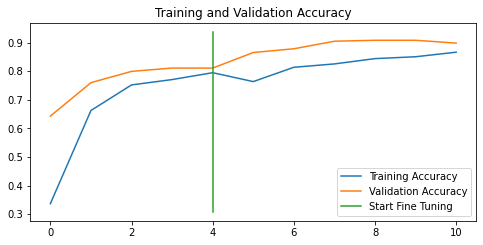

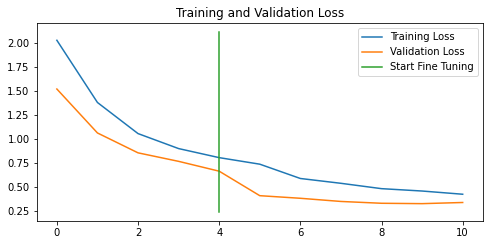

In [ ]:
# How did fine-tuning go with more data?
compare_history(original_history=history_10_percent_data_aug,
                new_history = history_fine_10_classes_full,
                initial_epochs = 5)

## Viewing our experiment data on TensorBoard

>**Note:** Anything you upload to TensorBoard.dev is going to be public. so if you have private data, do not upload.

In [ ]:
# View tensorboard log of transfer learning modelling experiments (should be 5 models)
# upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 classes" \
  --description "A Series of different transfer learning experiments with varying amount of data and fine-tuning" \
  --one_shot # EXit the uploader once it finished uploading

My TensorBoard experiments are available at: https://tensorboard.dev/experiment/e8WfwBXNT0eprXyosoA5iA/


In [ ]:
!tensorboard dev list

https://tensorboard.dev/experiment/e8WfwBXNT0eprXyosoA5iA/
	Name                 Transfer Learning Experiments with 10 Food101 classes
	Description          A Series of different transfer learning experiments with varying amount of data and fine-tuning
	Id                   e8WfwBXNT0eprXyosoA5iA
	Created              2022-01-14 07:15:18 (7 minutes ago)
	Updated              2022-01-14 07:15:23 (7 minutes ago)
	Runs                 10
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  4150191
https://tensorboard.dev/experiment/FD1QZNkRRz6veCWgoG8IDQ/
	Name                 EfficientNetB0 vs. ResNet50V2 vs. Mobilenetv2-100-224
	Description          Comparing three different TF Hub feature extraction model architectures using 10% of the training data
	Id                   FD1QZNkRRz6veCWgoG8IDQ
	Created              2022-01-11 04:46:40
	Updated              2022-01-11 04:46:43
	Runs                 6
	Tags                 5
	Scalars            